In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import RegularGridInterpolator, CubicSpline
import camb
from camb import model, initialpower


In [2]:
print(camb.__version__)


1.3.6


In [ ]:
# load data
zs = np.loadtxt('/home/alex/axionNL_new/optimal_z_array.dat')
ratios_copy = np.loadtxt('nonlinear_ratios.dat')
pknl_array = np.loadtxt('nonlinear_pks.dat')
k_array = np.loadtxt('cosmos_transfer_out.dat')[:,0] #Must copy from Alex's directory

In [ ]:
# interpolate pk
ratios_interp = RegularGridInterpolator((np.log10(k_array), zs), ratios_copy.T, method='linear', bounds_error=False,
    fill_value=1.0,)
pknl_interp = RegularGridInterpolator((np.log10(k_array), zs), np.log10(pknl_array).T, method='linear', bounds_error=False,
    fill_value=1.0,)

In [ ]:
# Run camb prediction (high-ish accuracy)

#For calculating large-scale structure and lensing results yourself, get a power spectrum
#interpolation object. In this example we calculate the CMB lensing potential power
#spectrum using the Limber approximation, using PK=camb.get_matter_power_interpolator() function.
#calling PK(z, k) will then get power spectrum at any k and redshift z in range.

nz = 100 #number of steps to use for the radial/redshift integration
kmax=10  #kmax to use
#First set up parameters as usual
pars = camb.CAMBparams()

#pars.set_cosmology(H0=67.4, ombh2=0.02237, omch2=0.12)
#pars.InitPower.set_params(ns=0.9655, As=2.2e-9)

pars.set_cosmology(H0=67.4, ombh2=0.02237, omch2=0.12, mnu=0.06, num_massive_neutrinos = 1, nnu=3.044)
pars.InitPower.set_params(ns=0.9655, As=2.2e-9)

pars.set_matter_power(accurate_massive_neutrino_transfers=True,k_per_logint=10)
pars.set_accuracy(AccuracyBoost=1.2, );

pars.set_for_lmax(9000,lens_potential_accuracy=2,nonlinear='mead2016',lens_margin=1050)
pars.NonLinear = model.NonLinear_both
pars.NonLinearModel.set_params('mead2016',)# HMCode_A_baryon = 3.13, HMCode_eta_baryon = 0.603)

#For Limber result, want integration over \chi (comoving radial distance), from 0 to chi_*.
#so get background results to find chistar, set up a range in chi, and calculate corresponding redshifts
results= camb.get_background(pars)
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs_camb=results.redshift_at_comoving_radial_distance(chis)
#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs_camb = zs_camb[1:-1]

#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#Here for lensing we want the power spectrum of the Weyl potential.
PK = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zs_camb[-1])

In [ ]:
pkml = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_tot,var2=model.Transfer_tot, zmax=zs_camb[-1])

pkmnl = camb.get_matter_power_interpolator(pars, nonlinear='mead2016', 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_tot,var2=model.Transfer_tot, zmax=zs_camb[-1])

In [ ]:
#Load my power spectra
import pickle

f_axionEmu_lin = open('/home/keir/keir/data_P_k_linear_2_LH_ACT_DR6_TTTEEEPP_nu6_100i_0.pkl', 'rb')
pk_emu_lin = pickle.load(f_axionEmu_lin)
f_axionEmu_lin.close()

f_axionEmu_nonlin = open('/home/keir/keir/data_P_k_nonlinear_2_LH_ACT_DR6_TTTEEEPP_nu6_100i_0.pkl', 'rb')
pk_emu_nonlin = pickle.load(f_axionEmu_nonlin)
f_axionEmu_nonlin.close()
print(pk_emu_lin, pk_emu_nonlin)


In [ ]:
#Calculate axionEmu non-linear/linear power ratio
pk_log_emu_lin_interp = RegularGridInterpolator((np.log10(pk_emu_lin['k_index'][0]),), np.log10(pk_emu_lin['matter_mg'][0]),
                                            method='linear', bounds_error=False, fill_value=1.0)
pk_log_emu_nonlin_interp = RegularGridInterpolator((np.log10(pk_emu_nonlin['k_index'][0]),), np.log10(pk_emu_nonlin['matter_mg'][0]),
                                            method='linear', bounds_error=False, fill_value=1.0)
pk_emu_ratio = (10. ** pk_log_emu_nonlin_interp((np.log10(pk_emu_lin['k_index'][0]),))) / pk_emu_lin['matter_mg'][0]
pk_emu_ratio2 =  pk_emu_nonlin['matter_mg'][0] / (10. ** pk_log_emu_lin_interp((np.log10(pk_emu_nonlin['k_index'][0]),)))


In [ ]:
#Plot comparison to Alex's power ratio
plt.semilogx(pk_emu_lin['k_index'][0], pk_emu_ratio, label=r'AxionEmu')
plt.semilogx(pk_emu_nonlin['k_index'][0], pk_emu_ratio2, label=r'AxionEmu2')
plt.semilogx(pk_emu_lin['k_index'][0], ratios_interp((np.log10(pk_emu_lin['k_index'][0]), pk_emu_lin['params']['z'][0])), label=r'Alex')
plt.ylabel(r'$P_{NL} / P_{L}$')
plt.xlabel(r'$k [h/Mpc]$')
plt.legend()
plt.yscale('log')
plt.axhline(y=1., color='black')


In [ ]:
plt.semilogx(pk_emu_lin['k_index'][0], pk_emu_ratio / ratios_interp((np.log10(pk_emu_lin['k_index'][0]), pk_emu_lin['params']['z'][0])))
plt.semilogx(pk_emu_nonlin['k_index'][0], pk_emu_ratio2 / ratios_interp((np.log10(pk_emu_nonlin['k_index'][0]), pk_emu_nonlin['params']['z'][0])))
plt.ylabel(r'$P_{NL} / P_{L}$ [AxionEmu / Alex]')
plt.xlabel(r'$k [h/Mpc]$')
#plt.legend()
#plt.yscale('log')
plt.axhline(y=1., color='black')
plt.xlim([1.e-3, 1.e+2])
plt.ylim([0.985, 1.1])


In [ ]:
# Compare the nonlinear ratios
ks = np.logspace(-3.5, 1, 300)
for z in zs[zs<=4]:
    plt.semilogx(ks, ratios_interp((np.log10(ks/0.674), z))/(pkmnl.P(z, ks)/pkml.P(z, ks))-1, label="z= " +str(round(z, 2)))
#plt.loglog(ks, ratios_interp((ks/0.674, 0.5)))
#plt.ylim(-0.03, 0.03)
plt.ylabel("$\Delta P(k)/P(k)$")
plt.xlabel('$k$')
plt.legend()
plt.grid()
plt.xlim(5e-4, 100)

In [ ]:
# Compare the nonlinear ratios for axionEmu output
ks = np.logspace(-3.5, 1, 300)
z = pk_emu_lin['params']['z'][0]
pk_emu_ratio = (10. ** pk_log_emu_nonlin_interp((np.log10(ks/0.674),))) / (10. ** pk_log_emu_lin_interp((np.log10(ks/0.674),)))
plt.semilogx(ks, ratios_interp((np.log10(ks/0.674), z))/(pkmnl.P(z, ks)/pkml.P(z, ks))-1, label="Alex; z= " +str(round(z, 2)))
plt.semilogx(ks, pk_emu_ratio/(pkmnl.P(z, ks)/pkml.P(z, ks))-1, label="AxionEmu; z= " +str(round(z, 2)))
#plt.loglog(ks, ratios_interp((ks/0.674, 0.5)))
#plt.ylim(-0.03, 0.03)
plt.ylabel("$\Delta P(k)/P(k)$")
plt.xlabel('$k$ [1/Mpc]')
plt.legend()
plt.grid()
plt.xlim(5e-4, 100)
plt.savefig('Alex_v_Keir_AxiECAMB_better.pdf')


In [ ]:
#Get lensing window function (flat universe)
win = ((chistar-chis)/(chis**2*chistar))**2
#Do integral over chi
ls = np.arange(2,4000+1, dtype=np.float64)
cl_kappa=np.zeros(ls.shape)
w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_kappa[i] = np.dot(dchis, w*PK.P(zs_camb, k, grid=False) *ratios_interp((np.log10(k/0.674), zs_camb)) *win/k**4)
cl_kappa*= (ls*(ls+1))**2

In [ ]:
#Load AxionEmu C_phi
f_axionEmu_C_ell = open('/home/keir/keir/data_C_ell_LH_ACT_DR6_TTTEEEPP_vary_cosmo_test_0.pkl', 'rb')
C_ell_emu = pickle.load(f_axionEmu_C_ell)
f_axionEmu_C_ell.close()

print(C_ell_emu)


In [ ]:
#Compare with CAMB's calculation:
#note that to get CAMB's internal calculation accurate at the 1% level at L~2000, 
#need lens_potential_accuracy=2. Increase to 4 for accurate match to the Limber calculation here

results = camb.get_results(pars)
cl_camb=results.get_lens_potential_cls(9000)[:,0]
#cl_camb[:,0] is phi x phi power spectrum (other columns are phi x T and phi x E)

#ls_camb, cl_camb = np.loadtxt('high_accuracy_camb_lensing.dat')

#Make plot. Expect difference at very low-L from inaccuracy in Limber approximation, and
#very high L from differences in kmax (lens_potential_accuracy is only 2, though good by eye here)
cl_limber= 4*cl_kappa/2/np.pi #convert kappa power to [l(l+1)]^2C_phi/2pi (what cl_camb is)
plt.loglog(ls,ls**.5*cl_limber, color='b')
plt.loglog(ls,ls**.5*cl_camb[2:cl_limber.shape[0]+2], color='r')
plt.loglog(ls, (ls**.5) * C_ell_emu['C_phi'][0][:cl_limber.shape[0]], color='g')
plt.xlim([1,3000])
plt.legend(['Limber','CAMB hybrid','AxionEmu'])
plt.ylabel('$L^{1/2}[L(L+1)]^2C_L^{\phi}/2\pi$')
plt.xlabel('$L$')
plt.show()

plt.semilogx(ls,cl_limber[:int(np.max(ls))-1]/cl_camb[2:cl_limber.shape[0]+2]-1, color='b')
plt.semilogx(ls,C_ell_emu['C_phi'][0][:cl_limber.shape[0]]/cl_camb[2:cl_limber.shape[0]+2]-1, color='g')
plt.xlim(40, 3000)
plt.ylim(-0.05, 0.05)
#plt.grid(ls=":")
plt.ylabel('$\Delta C^{\phi}_L/C^{\phi}_L$')
plt.xlabel('$L$')
plt.axhline(y=0.01, ls=':', c='grey')
plt.axhline(y=-0.01, ls=':', c='grey')
plt.axhline(y=0.0, ls='--', c='grey')
#plt.loglog(np.arange(2,cl_camb[:,0].size),cl_camb[2:,0], color='r')
plt.title('Updated Halo Model Lensing vs CAMB (high accuracy)')
plt.legend(['Limber','AxionEmu'])
plt.savefig('C_phi_test_better.pdf')


In [ ]:
import camb.correlations as cc


In [ ]:
#Check primary CMB
results = camb.get_results(pars)
cl_camb_primary=results.get_unlensed_scalar_cls(lmax=9000) * 7.4311e12 #, CMB_unit='muK'

#Manual lensing
#cl_camb_primary_lensed = cc.lensed_cls(cl_camb_primary, cl_camb)
cl_camb_primary_lensed = cc.lensed_cls(cl_camb_primary[:C_ell_emu['C_tt'][0].shape[0]+2, :], np.concatenate((np.zeros(2), C_ell_emu['C_phi'][0])))


In [ ]:
ell_primary = np.arange(2, C_ell_emu['C_tt'][0].shape[0]+2)
tt_ratio = C_ell_emu['C_tt'][0] / cl_camb_primary[2:C_ell_emu['C_tt'][0].shape[0]+2, 0] #_lensed
ee_ratio = C_ell_emu['C_ee'][0] / cl_camb_primary[2:C_ell_emu['C_ee'][0].shape[0]+2, 1]

plt.plot(ell_primary, tt_ratio, label='TT')
#plt.plot(ell_primary, C_ell_emu['C_te'][0] / cl_camb_primary[2:C_ell_emu['C_te'][0].shape[0]+2, 3], label='TE')
plt.plot(ell_primary, ee_ratio, label='EE')
#plt.plot(ell_primary, C_ell_emu['C_bb'][0] / cl_camb_primary_lensed[2:C_ell_emu['C_bb'][0].shape[0]+2, 2], label='BB')
plt.xlabel('$\ell$')
plt.ylabel('AxionEmu / CAMB')
plt.legend()
plt.ylim([0.9, 1.1])

print(tt_ratio, ee_ratio)
plt.savefig('C_primary_test.pdf')


In [ ]:
import pandas as pd

def compare_axionCAMB_CAMB_linear_Cls(cl_file):
    
    test_params = pd.read_pickle(cl_file)
    
    
    params_settings = {
    'omega_b': test_params['params']['omega_b'][0],
    'omega_cdm':  test_params['params']['omega_cdm'][0],
    'H0': test_params['params']['H_0'][0],
    'tau_reio': test_params['params']['tau_reio'][0],
    'ln10^{10}A_s': np.log(test_params['params']['A_s'][0]*1e10),
    'n_s': test_params['params']['n_s'][0],

    'N_ncdm': 1,
    'N_ur': 2.044,
    'm_ncdm': 0.06
    }
    
    pars = camb.set_params(H0=test_params['params']['H_0'][0], 
                           ombh2=test_params['params']['omega_b'][0], 
                           omch2=test_params['params']['omega_cdm'][0], 
                           mnu=0.06, omk=0, 
                           tau=test_params['params']['tau_reio'][0],  
                           As=test_params['params']['A_s'][0], 
                           ns=test_params['params']['n_s'][0], lmax=11000, 
                           lens_potential_accuracy=6, lAccuracyBoost =4, lSampleBoost=4)
    
    pars.NonLinear = model.NonLinear_none
    
    #l_max_scalars = 11000
    #cszfast = classy_szfast.Class_szfast(**params_settings)
    
    #params_cp = {}
    #for key,value in params_settings.items():
    #    params_cp[key] = [value]
    
    #params_cp['z_pk_save_nonclass'] = test_params['params']['z']
    
    #mp = 'lcdm'
    #predicted_tt_spectrum = cszfast.cp_tt_nn[mp].ten_to_predictions_np(params_cp)
    #predicted_te_spectrum = cszfast.cp_te_nn[mp].predictions_np(params_cp)
    #predicted_ee_spectrum = cszfast.cp_ee_nn[mp].ten_to_predictions_np(params_cp)
    #predicted_pp_spectrum = cszfast.cp_pp_nn[mp].ten_to_predictions_np(params_cp)
    results = camb.get_results(pars)
    
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
    
    totCL = powers['unlensed_scalar']#powers['total']
    ls = np.arange(totCL.shape[0])
    print(test_params.keys())

    #Manual lensing
    totCL = cc.lensed_cls(totCL[:test_params['C_tt'][0].shape[0]+2, :], cl_camb[:test_params['C_tt'][0].shape[0]+2])
    #np.concatenate((np.zeros(2), test_params['C_phi'][0])))
    ls = ls[:test_params['C_tt'][0].shape[0]+2]

    plt.plot(test_params['l_index'][0], 
               test_params['C_tt'][0], label='TT; AxionEmu')
    plt.plot(test_params['l_index'][0], 
               test_params['C_ee'][0], label='EE; AxionEmu')
    plt.plot(test_params['l_index'][0], 
               test_params['C_bb'][0], label='BB; AxionEmu')

    plt.plot(test_params['l_index'][0], 
               CubicSpline(ls,totCL[:,0])(test_params['l_index'][0]), label='TT; CAMB')
    plt.plot(test_params['l_index'][0], 
               CubicSpline(ls,totCL[:,1])(test_params['l_index'][0]), label='EE; CAMB')
    plt.plot(test_params['l_index'][0], 
               CubicSpline(ls,totCL[:,2])(test_params['l_index'][0]), label='BB; CAMB')
    plt.yscale('log')
    plt.xlabel('$\ell$')
    plt.ylabel('$D_\ell$')
    plt.legend()
    plt.savefig('C_primary_lensed_test_better.pdf')

    plt.show()
    plt.axhline(y=0., color='black', ls='-')
    plt.plot(test_params['l_index'][0], 
               test_params['C_tt'][0]/CubicSpline(ls,totCL[:,0])(test_params['l_index'][0])-1, label='TT')
    plt.plot(test_params['l_index'][0], 
               test_params['C_ee'][0]/CubicSpline(ls,totCL[:,1])(test_params['l_index'][0])-1, label='EE')
    plt.plot(test_params['l_index'][0], 
               test_params['C_bb'][0]/CubicSpline(ls,totCL[:,2])(test_params['l_index'][0])-1, label='BB')
    plt.ylim(-0.02, 0.3)
    plt.axhline(y=0.01, color='black', ls=':')
    plt.axhline(y=-0.01, color='black', ls=':')
    plt.xlabel('$\ell$')
    plt.ylabel('(AxionEmu - CAMB) / CAMB')
    plt.legend()
    plt.savefig('C_primary_lensed_test_better.pdf')

    clpp = results.get_lens_potential_cls(lmax=11000)
    #plt.loglog(np.arange(2001), cl[:,0])
    clpp_camb = CubicSpline(np.arange(len(clpp)),clpp[:,0])
    
    #plt.semilogx(test_params['l_index'][0][2:], 
    #           test_params['C_phi'][0][2:]/(test_params['l_index'][0][2:])/2/np.pi -1)
    ##plt.show()
    #plt.semilogx(test_params['l_index'][0][2:], 
                 #test_params['C_phi'][0][2:len(test_params['l_index'][0])]/
                 #clpp_camb(test_params['l_index'][0][2:])-1)
    ##plt.loglog(test_params['l_index'][0][2:], test_params['C_phi'][0][2:len(test_params['l_index'][0])], lw=3)
    ##plt.loglog(test_params['l_index'][0][2:], clpp_camb(test_params['l_index'][0][2:]))
    
    out = [test_params['l_index'][0][2:], 
           test_params['C_tt'][0][2:]/CubicSpline(ls,totCL[:,0])(test_params['l_index'][0][2:])-1,
           test_params['C_ee'][0][2:]/CubicSpline(ls,totCL[:,1])(test_params['l_index'][0][2:])-1, 
           test_params['l_index'][0][2:], 
           test_params['C_phi'][0][2:len(test_params['l_index'][0])]/clpp_camb(test_params['l_index'][0][2:])-1]
    return out


In [ ]:
compare_axionCAMB_CAMB_linear_Cls('/home/keir/keir/data_C_ell_LH_ACT_DR6_TTTEEEPP_nu6_100i_0.pkl')


In [18]:
#Current cell for testing

def compare_axionCAMB_CAMB_Cls(cl_files):
    for i, cl_file in enumerate(cl_files):
        print(i, cl_file)

        if i == 0:
            out = []

        test_params = pd.read_pickle(cl_file)
        file_idx = 0

        if len(test_params['params']['omega_b']) < 1:
            print('No file')
            continue

        params_settings = {
        'omega_b': test_params['params']['omega_b'][file_idx],
        'omega_cdm':  test_params['params']['omega_cdm'][file_idx],
        'H0': test_params['params']['H_0'][file_idx],
        'tau_reio': test_params['params']['tau_reio'][file_idx],
        'ln10^{10}A_s': np.log(test_params['params']['A_s'][file_idx]*1e10),
        'n_s': test_params['params']['n_s'][file_idx],
    
        'N_ncdm': 1,
        'N_ur': 2.044,
        'm_ncdm': 0.06
        }
        
        pars = camb.set_params(H0=test_params['params']['H_0'][file_idx], 
                               ombh2=test_params['params']['omega_b'][file_idx], 
                               omch2=test_params['params']['omega_cdm'][file_idx], 
                               mnu=0.06, omk=0, 
                               tau=test_params['params']['tau_reio'][file_idx],  
                               As=test_params['params']['A_s'][file_idx], 
                               ns=test_params['params']['n_s'][file_idx]) #, min_l_logl_sampling=6000) #, lmax=11000, 
        #                       lens_potential_accuracy=8, lAccuracyBoost =4, lSampleBoost=4)
        
        ##pars.NonLinear = model.NonLinear_none
        pars.set_matter_power(k_per_logint=130,kmax=10., nonlinear=True) #accurate_massive_neutrino_transfers=True,
        pars.set_accuracy(AccuracyBoost=2., lSampleBoost=2., lAccuracyBoost=1.2, DoLateRadTruncation=False)
    
        pars.set_for_lmax(11000,lens_potential_accuracy=8,lens_margin=2050) #nonlinear='True',
        ##pars.NonLinear = model.NonLinear_both
        pars.NonLinearModel.set_params('mead2020', HMCode_A_baryon = 3.13, HMCode_eta_baryon = 0.603)
        
        #l_max_scalars = 11000
        #cszfast = classy_szfast.Class_szfast(**params_settings)
        
        #params_cp = {}
        #for key,value in params_settings.items():
        #    params_cp[key] = [value]
        
        #params_cp['z_pk_save_nonclass'] = test_params['params']['z']
        
        #mp = 'lcdm'
        #predicted_tt_spectrum = cszfast.cp_tt_nn[mp].ten_to_predictions_np(params_cp)
        #predicted_te_spectrum = cszfast.cp_te_nn[mp].predictions_np(params_cp)
        #predicted_ee_spectrum = cszfast.cp_ee_nn[mp].ten_to_predictions_np(params_cp)
        #predicted_pp_spectrum = cszfast.cp_pp_nn[mp].ten_to_predictions_np(params_cp)
        results = camb.get_results(pars)
        
        powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
        
        totCL = powers['total']
        ls = np.arange(totCL.shape[0])
        print(test_params.keys())

        if i == 0:
            fig, axes = plt.subplots(nrows=3, figsize=(10, 15))

        ell = test_params['l_index'][file_idx]
        ratio_TT = test_params['C_tt'][file_idx]/CubicSpline(ls,totCL[:,0])(test_params['l_index'][file_idx])
        ratio_EE = test_params['C_ee'][file_idx]/CubicSpline(ls,totCL[:,1])(test_params['l_index'][file_idx])
        ratio_BB = test_params['C_bb'][file_idx]/CubicSpline(ls,totCL[:,2])(test_params['l_index'][file_idx])


        # Relative errors lensing of ACT and Planck (approximate)
        bin_mat_act = np.loadtxt('/home/alex/TD_axionHMcode/axionHMcode/v1.2/binning_matrix_act.txt')
        bin_cen_act = np.dot(bin_mat_act, np.arange(bin_mat_act.shape[1]))

        bin_mat_planck = np.loadtxt('/home/alex/TD_axionHMcode/axionHMcode/v1.2/binning_matrix_planck.txt')
        bin_cen_planck = np.dot(bin_mat_planck, np.arange(bin_mat_planck.shape[1]))

        bin_cens = np.concatenate((bin_cen_act, bin_cen_planck))

        err = np.sqrt(np.diag(np.loadtxt('/home/alex/TD_axionHMcode/axionHMcode/v1.2/covmat_actplanck_cmbmarg.txt')))
        vals_act = np.loadtxt('/home/alex/TD_axionHMcode/axionHMcode/v1.2/clkk_bandpowers_act.txt')
        vals_planck = np.loadtxt('/home/alex/TD_axionHMcode/axionHMcode/v1.2/clkk_bandpowers_planck.txt')
        rel_err = err/ np.concatenate((vals_act, vals_planck))


        axes[0].semilogx(ell, ratio_TT, label='TT', color='cyan', lw=0.5)
        axes[0].semilogx(ell, ratio_EE, label='EE', color='magenta', lw=0.5)
        axes[0].semilogx(ell, ratio_BB, label='BB', color='orange', lw=0.5)
    
        axes[0].set_ylim(0.9, 1.1)
        axes[0].axhline(y=1.01, color='black', ls=':')
        axes[0].axhline(y=1., color='black', ls='-')
        axes[0].axhline(y=0.99, color='black', ls=':')
        if i == 0:
            axes[0].set_xlabel('$\ell$')
            axes[0].set_ylabel('AxionEmu / CAMB')
            axes[0].legend()
        #axes[0].savefig('C_ell_primary_vary_cosmo_test.pdf')
        
        clpp = powers['lens_potential'] ##results.get_lens_potential_cls(lmax=11000)
        #plt.loglog(np.arange(2001), cl[:,0])
        clpp_camb = CubicSpline(np.arange(len(clpp)),clpp[:,0])
        
        #plt.semilogx(test_params['l_index'][0][2:], 
        #           test_params['C_phi'][0][2:]/(test_params['l_index'][0][2:])/2/np.pi -1)
        ##plt.show()
        #plt.semilogx(test_params['l_index'][0][2:], 
                     #test_params['C_phi'][0][2:len(test_params['l_index'][0])]/
                     #clpp_camb(test_params['l_index'][0][2:])-1)
        axes[1].loglog(test_params['l_index'][file_idx], test_params['C_phi'][file_idx][:len(test_params['l_index'][file_idx])], lw=0.5, label='AxionEmu',
                       color='red')
        axes[1].loglog(test_params['l_index'][file_idx], clpp_camb(test_params['l_index'][file_idx]), label='CAMB', color='blue', lw=0.5)
        if i == 0:
            axes[1].set_xlabel('$L$')
            axes[1].set_ylabel('$C_{\phi\phi}$')
            axes[1].legend()
        ##plt.savefig('C_phi_vary_cosmo_test.pdf')
    
        ##plt.show()
        ratio_pp = test_params['C_phi'][file_idx][:len(test_params['l_index'][file_idx])] / clpp_camb(test_params['l_index'][file_idx])

        axes[2].plot(ell, ratio_pp, label='$\phi\phi$', color='green', lw=0.5)
        axes[2].set_xscale('log')
        axes[2].axhline(y=1.01, color='black', ls=':')
        axes[2].axhline(y=1., color='black', ls='-')
        axes[2].axhline(y=0.99, color='black', ls=':')
        axes[2].axvline(x=8, color='black', ls=':')

        #Add data errors
        axes[2].fill_between(bin_cens[18:], y1=1.+(0.1*rel_err[18:]), y2=1.-(0.1*rel_err[18:]), alpha=0.2, label=r'0.1 * Planck uncertainty')
        axes[2].fill_between(bin_cens[:18], y1=1.+(0.1*rel_err[:18]), y2=1.-(0.1*rel_err[:18]), alpha=0.4, label=r'0.1 * ACT uncertainty')

        if i == 0:
            axes[2].set_xlabel('$L$')
            axes[2].set_ylabel('AxionEmu / CAMB')
            axes[2].legend()
        if i == len(cl_files) - 1:
            plt.savefig('C_ell_test_Planck_data_error_10pc_2.pdf')
        out.append([ell, ratio_TT, ratio_EE, ratio_BB, ratio_pp, params_settings])

    return out


0 /home/keir/keir/data_C_ell_LH_ACT_DR6_TTTEEEPP_derived_Planck_LCDM_gfortran_orig_fast_0.pkl
dict_keys(['l_index', 'C_tt', 'C_ee', 'C_bb', 'C_te', 'C_phi', 'PkNL', 'PkL', 'k_out', 'k_out2', 'z_out', 'weyl', 'time', 'problem_list', 'problem_list_r', 'params'])
1 /home/keir/keir/data_C_ell_LH_ACT_DR6_TTTEEEPP_derived_Planck_LCDM_gfortran_orig_fast_1.pkl
dict_keys(['l_index', 'C_tt', 'C_ee', 'C_bb', 'C_te', 'C_phi', 'PkNL', 'PkL', 'k_out', 'k_out2', 'z_out', 'weyl', 'time', 'problem_list', 'problem_list_r', 'params'])


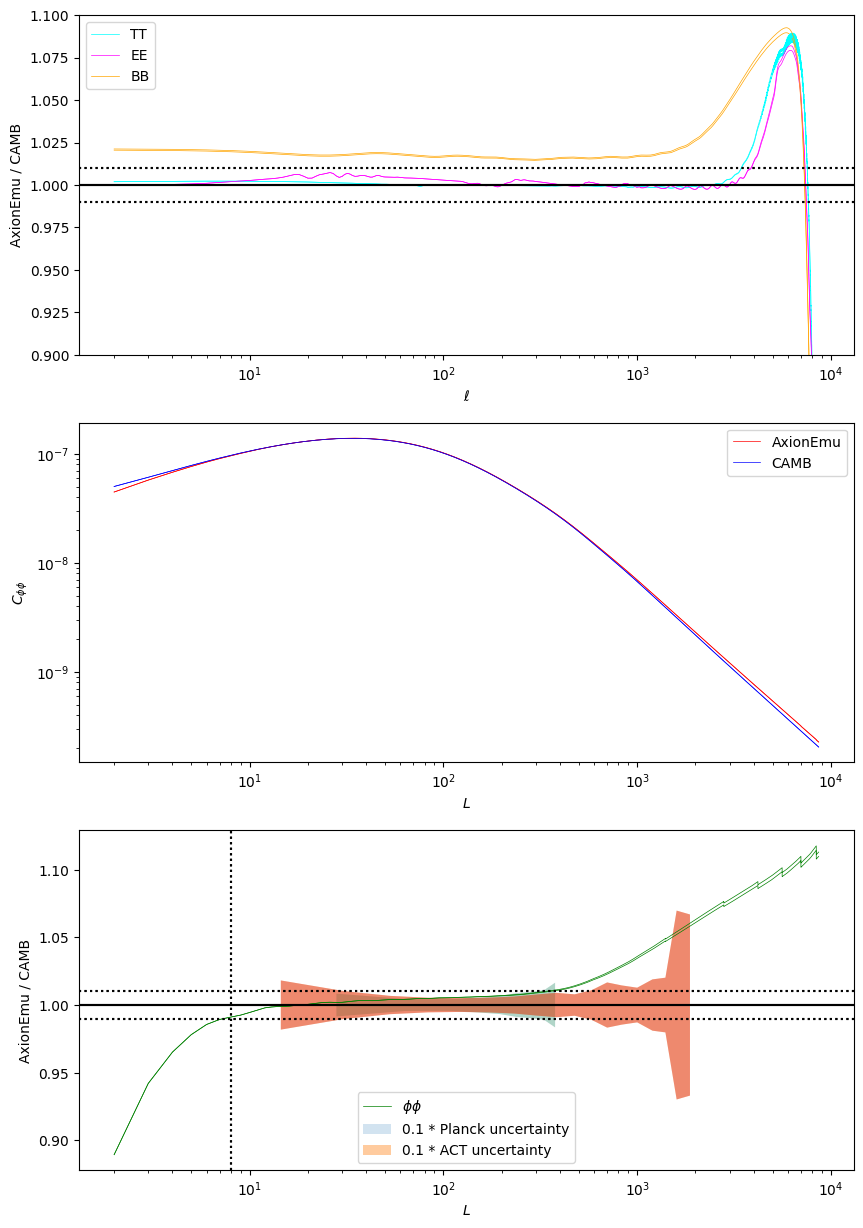

In [19]:
ratios = compare_axionCAMB_CAMB_Cls(['/home/keir/keir/data_C_ell_LH_ACT_DR6_TTTEEEPP_derived_Planck_LCDM_gfortran_orig_fast_%i.pkl'%i for i in range(2)])


In [ ]:
#Check power spectrum ratios
#print(ratios[0][4])
ratios_pp = np.array([ratios[i][4] for i in range(len(ratios))])
print(ratios_pp)
idx_bad = np.where(np.sum(ratios_pp > 1.01, axis=1) > 0)
print(idx_bad)


In [ ]:
ratios_bad = compare_axionCAMB_CAMB_Cls(['/home/keir/keir/data_C_ell_LH_ACT_DR6_TTTEEEPP_vary_cosmo_test_%i.pkl'%i for i in range(33,34)])


In [ ]:
ratios_bad


In [ ]:
p_k_lin = pd.read_pickle('/home/keir/keir/data_P_k_linear_1_LH_ACT_DR6_TTTEEEPP_vary_cosmo_test_33.pkl')
print(p_k_lin)


In [13]:
# Relative errors lensing of ACT and Planck (approximate)
bin_mat_act = np.loadtxt('/home/alex/TD_axionHMcode/axionHMcode/v1.2/binning_matrix_act.txt')
bin_cen_act = np.dot(bin_mat_act, np.arange(bin_mat_act.shape[1]))

bin_mat_planck = np.loadtxt('/home/alex/TD_axionHMcode/axionHMcode/v1.2/binning_matrix_planck.txt')
bin_cen_planck = np.dot(bin_mat_planck, np.arange(bin_mat_planck.shape[1]))

bin_cens = np.concatenate((bin_cen_act, bin_cen_planck))

err = np.sqrt(np.diag(np.loadtxt('/home/alex/TD_axionHMcode/axionHMcode/v1.2/covmat_actplanck_cmbmarg.txt')))
vals_act = np.loadtxt('/home/alex/TD_axionHMcode/axionHMcode/v1.2/clkk_bandpowers_act.txt')
vals_planck = np.loadtxt('/home/alex/TD_axionHMcode/axionHMcode/v1.2/clkk_bandpowers_planck.txt')
rel_err = err/ np.concatenate((vals_act, vals_planck))

print(bin_cens)
print(rel_err)


[  14.5          30.5          53.           83.5         123.
  172.          231.5         301.5         382.5         476.
  582.          700.5         832.5        1001.         1200.
 1400.         1600.         1874.           28.06508999   63.52603697
  106.22899452  150.4380889   195.1363403   240.27248645  285.79599611
  331.4214645   377.28076455]
[0.18151387 0.10349905 0.06762778 0.05387124 0.0510381  0.05467817
 0.06275152 0.07772728 0.08993423 0.07896292 0.10932745 0.16685868
 0.14490243 0.12799386 0.18935837 0.20205265 0.6974774  0.6689731
 0.08430954 0.04386596 0.04268606 0.05441073 0.06649162 0.08861452
 0.09747804 0.10992096 0.16486546]
